In [18]:
###########################
######### IMPORTS #########
###########################
import numpy as np
import random
import pickle
import pandas as pd
from scipy.constants import k
import math

In [19]:
#########################################
#########    USER  VARIABLES    #########
#########################################
# L = float(input("length of each side of the simulation cubic box > "))
# σ = float(input("particle density > "))
# m = float(input("mass of particles in atomic mass units > "))
# T = float(input("temperature of dark matter > "))
# Δt = float(input("time step > "))
# Nt = int(input("total duration > "))
# fsalida = int(input("data writing frequency > "))
# ftray = int(input("trajectory writing frequency > "))
# fvel = int(input("velocity writing frequency > "))

In [141]:
#########################################
#########  TESTING  VARIABLES   #########
#########################################
L = 20
σ = 0.003
m = 18 #uma
T = 30
Δt = 0.5
Nt = 200
fsalida = 1
ftray = 1
fvel = 10

In [151]:
#############################
######### FUNCIONES #########
#############################

def VelocitiesInit(N, T, m):
    """
    Int -> Int -> Float -> 2darray
    Assigns random velocities to the particles based on the Maxwell-Boltzmann distribution.
    """
    mean = 0
    std_dev = np.sqrt(0.005 * T / m)
    velocities = np.random.normal(loc=mean, scale=std_dev, size=(N, 3))
    return velocities

def ForceCalculation(Coords, L, verbose=False):
    """
    Dict -> Dict
    
    Calculates the net force acting on each particle based on the Lennard-Jones potential and the coordinates of the particles provided as arguments (Coords).
    """
    atomSize = 1    # Particles size
    Energia = 0
    Forces = np.zeros((3, len(Coords)))
    dfForces = pd.DataFrame(Forces, columns=range(len(Coords)))
    eps = 0.1 * 0.997 # kJ/mol      # Lennard-Jones Potential epsilon constant (Characteristic energy)
    alfa = 1     # Alpha constant of the Lennard-Jones Potential (Force of attraction of particles)
    cutoff = L/2  # Cutting distance for force calculation
    
    for i in range(Nparticulas):
        for j in range(i+1, Nparticulas):
            #print(i, " ", j)
            # 3D distances calculation
            dist_x = Coords[i][0] - Coords[j][0]
            dist_y = Coords[i][1] - Coords[j][1]
            dist_z = Coords[i][2] - Coords[j][2]
            
            # Periodic Boundary Conditions 
            dist_x = dist_x - L * np.round(dist_x / L)
            dist_y = dist_y - L * np.round(dist_y / L)
            dist_z = dist_z - L * np.round(dist_z / L)


            dist_ij = math.sqrt(dist_x**2 + dist_y**2 + dist_z**2)
            if verbose and (i % 10 == 0):
                print(f"dist atom {i} and {j}: {dist_ij}")
            # Calculation of potential energy and force using the truncated Lennard-Jones potential
            if dist_ij <= cutoff:
                E_ij = 4 * eps * ((atomSize/dist_ij)**12 - alfa * (atomSize/dist_ij)**6)
                Fx_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_x / dist_ij)
                Fy_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_y / dist_ij)
                Fz_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_z / dist_ij)
                
                Energia += E_ij  # Sum of potential energy
                
                # Storing forces in the Forces dictionary
                dfForces[i].iloc[0] += Fx_ij
                dfForces[i].iloc[1] += Fy_ij
                dfForces[i].iloc[2] += Fz_ij

                dfForces[j].iloc[0] += -Fx_ij
                dfForces[j].iloc[1] += -Fy_ij
                dfForces[j].iloc[2] += -Fz_ij
    
    # At the end of this loop, Forces will contain the forces acting on each particle.
    return dfForces, Energia
    
def toDF(Coords):
    """Dict -> Dataframe
    Passes the coordinates (Dict) to a DataFrame. Prepare data to save as PDB"""
    
    cords = pd.DataFrame(Coords, index = ["x", "y", "z"]).T
    cords["serial"] = np.array(list(range(Nparticulas)))
    numbers = ['resseq', 'beta']
    for n in numbers:
        cords[f"{n}"] = 1
    
    cords["name"] = "O"
    cords["resname"] = "ALA"
    cords["ATOM"] = "ATOM"
    
    cords = cords[["ATOM", "serial", "name", "resname", "resseq", "x", "y", "z", "beta"]]
    return cords
    
def writePDB(ofile, pdb):
    """
    DataFrame -> PDB

    Save system coordinate data (DataFrame) in PDB format file
    """
    #col_space = [4, 7, 3, 6, 6, 12, 8, 8, 6]
    col_space = [4, 7, 3, 3, 3, 11, 8, 8, 6]
    pdb.to_string(ofile, index=False, header=None, col_space=col_space)

In [160]:
###############################
######### INIT SYSTEM #########
###############################
import numpy as np
import random

try:
    # Calculate the distance between atoms based on density (σ)
    AtomsDist = 1 / (σ ** (1/3))

    # Generates a three-dimensional grid with more distributed positions
    grilla = [
        np.round(np.array((i, j, k)), 2)
        for i in np.arange(0, L - AtomsDist/2, AtomsDist/2)
        for j in np.arange(0, L - AtomsDist/2, AtomsDist/2)
        for k in np.arange(0, L - AtomsDist/2, AtomsDist/2)
    ]

    # Calculate the total number of particles from the density and size of the box
    Nparticulas = int(L**3 * σ)

    # Verify that there are enough positions in the grid for the number of particles
    if len(grilla) < Nparticulas:
        raise ValueError("Error: densidad demasiado baja para el tamaño de la caja")

    # Select random grid positions for particles
    atomIDs = [i for i in range(Nparticulas)]
    atomPos = random.sample(grilla, Nparticulas)
    Coords = dict(zip(atomIDs, atomPos))
except ValueError as e:
    print(e)
except Exception as ex:
    print("Unknown error:", ex)


In [161]:
atomSize = 1    # Particles size
Energia = 0
Forces = np.zeros((3, len(Coords)))
dfForces = pd.DataFrame(Forces, columns=range(len(Coords)))
eps = 0.1 * 0.997 # kJ/mol      # Lennard-Jones Potential epsilon constant (Characteristic energy)
alfa = 1     # Alpha constant of the Lennard-Jones Potential (Force of attraction of particles)
cutoff = L/2  # Cutting distance for force calculation

for i in range(Nparticulas):
    for j in range(i+1, Nparticulas):
        # 3D distances calculation
        dist_x = Coords[i][0] - Coords[j][0]
        dist_y = Coords[i][1] - Coords[j][1]
        dist_z = Coords[i][2] - Coords[j][2]

        # Periodic Boundary Conditions
        dist_x = dist_x - L * np.round(dist_x / L)
        dist_y = dist_y - L * np.round(dist_y / L)
        dist_z = dist_z - L * np.round(dist_z / L)

        dist_ij = math.sqrt(dist_x**2 + dist_y**2 + dist_z**2)
        # Calculation of potential energy and force using the truncated Lennard-Jones potential
        if dist_ij <= cutoff:
            E_ij = 4 * eps * ((atomSize/dist_ij)**12 - alfa * (atomSize/dist_ij)**6)
            Fx_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_x / dist_ij)
            Fy_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_y / dist_ij)
            Fz_ij = 4 * eps * (12 * (atomSize**12 / dist_ij**13) - 6 * alfa * (atomSize**6 / dist_ij**7)) * (dist_z / dist_ij)

            Energia += E_ij  # Sum of potential energy

            # Storing forces in the Forces dictionary
            
            dfForces[i].iloc[0] += Fx_ij
            dfForces[i].iloc[1] += Fy_ij
            dfForces[i].iloc[2] += Fz_ij

            dfForces[j].iloc[0] += -Fx_ij
            dfForces[j].iloc[1] += -Fy_ij
            dfForces[j].iloc[2] += -Fz_ij

In [162]:
#### Initialization of output files ####

outName = input("Name of output files > ") or "test"

# Ad-hoc output name setting
# outName = "testeoPBC"
# Trajectory output file
pdbfile = open(f"{outName}.pdb", "w")
pdbfile.close()

In [163]:
#Coords en t = 0
cords = toDF(Coords)
pdbfile = open(f"{outName}.pdb", "a+")
pdbfile.write(f"Model    0\n")
writePDB(pdbfile, cords)
pdbfile.write("\nENDMDL\n")
pdbfile.close()

In [164]:
############################################
######### INIT OUTPUT VARIABLES #########
############################################

# Initialization of velocities and coordinates
Vels = VelocitiesInit(Nparticulas, T, m)
CoordsNext = pickle.loads(pickle.dumps(Coords))

# List to store the values of Epot (Potential Energy), Ecin (Kinetic Energy) and Etot (Total Energy)
Epots = []
Ecins = []
Etots = []


Vels_out = Vels[:, :, np.newaxis] # The velocity array is initialized (The initial vels are not saved unless fvel > 1)


In [165]:
# First integration of the equations of motion

Forces, Epot = ForceCalculation(Coords, L, verbose = False)
Epots.append(Epot)
Ecin = 0.5 * m * np.sum(Vels**2)
Ecins.append(Ecin)
Etot = Epot + Ecin
Etots.append(Etot)
# Updating positions using the Verlet method
for atom in Coords.keys():
    x = Coords[atom][0] + Vels[atom][0] * Δt + 0.5 * (Forces[atom][0] / m) * Δt**2
    y = Coords[atom][1] + Vels[atom][1] * Δt + 0.5 * (Forces[atom][1] / m) * Δt**2
    z = Coords[atom][2] + Vels[atom][2] * Δt + 0.5 * (Forces[atom][2] / m) * Δt**2

    vx = (x - Coords[atom][0]) / Δt
    vy = (y - Coords[atom][1]) / Δt
    vz = (z - Coords[atom][2]) / Δt
    
    # Periodic Boundary Conditions
    x = x % L
    y = y % L
    z = z % L


    CoordsNext[atom] = [np.round(x, 3), np.round(y, 3), np.round(z, 3)]


    Vels[atom] = np.array([vx, vy, vz])

Vels_out = np.concatenate((Vels_out, Vels[:, :, np.newaxis]), axis=2)
#Coords at t = 1
cords = toDF(CoordsNext)
pdbfile = open(f"{outName}.pdb", "a+")
pdbfile.write(f"Model    1\n")
writePDB(pdbfile, cords)
pdbfile.write("\nENDMDL\n")
pdbfile.close()

In [166]:
                                            #########################################
                                            ######### MAIN : EQs of Motion  #########
                                            #########################################

for step in range(1, int((Nt + 1)//Δt)):
    Coords = pickle.loads(pickle.dumps(CoordsNext))
    Forces, Epot = ForceCalculation(Coords, L, verbose=False)
    Epots.append(Epot)
    Ecin = 0.5 * m * np.sum(Vels**2)
    Ecins.append(Ecin)
    Etot = Epot + Ecin
    Etots.append(Etot)
    # Updating positions using the Verlet method
    for atom in Coords.keys():
        x = Coords[atom][0] + Vels[atom][0] * Δt + 0.5 * (Forces[atom][0] / m) * Δt**2
        y = Coords[atom][1] + Vels[atom][1] * Δt + 0.5 * (Forces[atom][1] / m) * Δt**2
        z = Coords[atom][2] + Vels[atom][2] * Δt + 0.5 * (Forces[atom][2] / m) * Δt**2

        vx = (x - Coords[atom][0]) / Δt
        vy = (y - Coords[atom][1]) / Δt
        vz = (z - Coords[atom][2]) / Δt
        
#         # Periodic Boundary Conditions
        x = x % L
        y = y % L
        z = z % L

        CoordsNext[atom] = [np.round(x, 3), np.round(y, 3), np.round(z, 3)]

        # Updating speeds using the Verlet method
        
        Vels[atom] = np.array([vx, vy, vz])

    Vels_out = np.concatenate((Vels_out, Vels[:, :, np.newaxis]), axis=2)
    #Coords at t + Δt
    cords = toDF(CoordsNext)
    pdbfile = open(f"{outName}.pdb", "a+")
    pdbfile.write(f"Model    {step}\n")
    writePDB(pdbfile, cords)
    pdbfile.write("\nENDMDL\n")
    pdbfile.close()
    
# Saving of Energies in Numpy's array
np.save(f"{outName}energy", np.concatenate((np.array(Epots)[np.newaxis].T[::fsalida], np.array(Ecins)[np.newaxis].T[::fsalida], np.array(Etots)[np.newaxis].T[::fsalida]), axis=1))

# Saving of speeds in Numpy's array
np.save(f"{outName}vels", Vels_out[:,:,::fvel])

## Visualization of Speeds and Energies

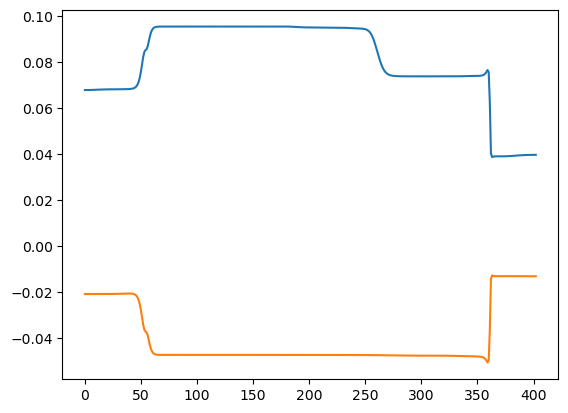

In [184]:
import matplotlib.pyplot as plt
plt.plot(Vels_out[0][2]) # z component of speed for atom of index 0 
plt.plot(Vels_out[22][2]) # z component of speed for atom of index 22

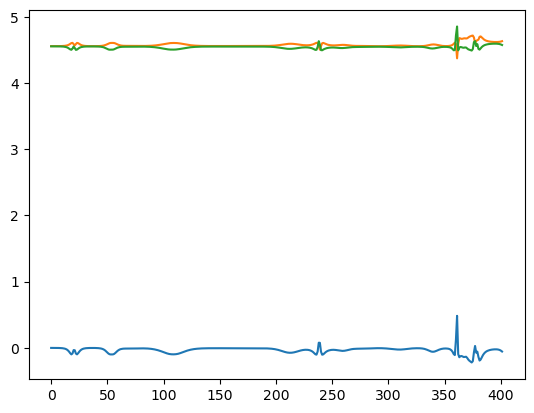

In [182]:
plt.plot(Epots) # blue
plt.plot(Ecins) # orange
plt.plot(Etots) # green